In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from geopy.distance import geodesic
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import math
from keras.models import load_model

In [2]:
laundry = pd.read_csv('https://raw.githubusercontent.com/anisimnida/Spin-Cycle/main/machine-learning/cleaned%20data/laundry.csv')

In [3]:
laundry.isna().sum()

ID Laundry           0
Name                 0
Fulladdress          2
Categories           0
phone              131
Review Count         0
Average Rating       0
Review URL          24
Google Maps URL      0
Latitude             0
Longitude            0
Website            760
Opening Hours      102
Featured Image       8
Layanan              3
dtype: int64

In [4]:
laundry = laundry.fillna('None')
laundry.isna().sum()

ID Laundry         0
Name               0
Fulladdress        0
Categories         0
phone              0
Review Count       0
Average Rating     0
Review URL         0
Google Maps URL    0
Latitude           0
Longitude          0
Website            0
Opening Hours      0
Featured Image     0
Layanan            0
dtype: int64

# Model_Near

In [5]:
def prepare_data(laundry, user_location):
    # Menambahkan fitur jarak ke lokasi pengguna
    laundry['Distance'] = laundry.apply(lambda row: geodesic(user_location, (row['Latitude'], row['Longitude'])).km, axis=1)

    # Membuat fitur dan label dengan fitur jarak
    features = laundry[['Latitude', 'Longitude', 'Distance']]
    labels = laundry['Average Rating']

    # Split data menjadi train dan test
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Normalisasi fitur
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [6]:
# Membangun Model
def build_model():
    # Input layer
    latitude_input = Input(shape=(1,), name='latitude')
    longitude_input = Input(shape=(1,), name='longitude')
    distance_input = Input(shape=(1,), name='distance')

    # Dense layers
    concat = Concatenate()([latitude_input, longitude_input, distance_input])
    dense1 = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(concat)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout2)
    dense4 = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(dense3)
    output = Dense(1)(dense4)

    # Model
    model = Model(inputs=[latitude_input, longitude_input, distance_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')  # Use MSE as the loss function

    return model

In [7]:
def train_model(model, X_train_scaled, X_test_scaled, y_train, y_test):
    # Membuat dataset TensorFlow dengan dua input terpisah
    def split_lat_lon_distance(features, label):
        latitude = features[0]
        longitude = features[1]
        distance = features[2]
        return {'latitude': latitude, 'longitude': longitude, 'distance': distance}, label

    # Membuat dataset dengan map function untuk memisahkan latitude dan longitude
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train.values))
    train_dataset = train_dataset.shuffle(buffer_size=len(X_train_scaled)).map(split_lat_lon_distance).batch(32)

    test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test.values))
    test_dataset = test_dataset.map(split_lat_lon_distance).batch(32)

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Melatih model
    history = model.fit(train_dataset, epochs=200, validation_data=test_dataset, callbacks=[early_stopping])

    # Evaluasi model
    loss = model.evaluate(test_dataset)
    print("Test Loss:", loss)

    # Prediksi
    y_pred = model.predict(test_dataset).flatten()  # Pastikan bentuknya sesuai
    # Menghitung metrik tambahan
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Absolute Error:", mae)
    print("Mean Squared Error:", mse)

    return history

In [8]:
def save_model(model, filename):
    model.save(filename)

def main(laundry, user_location):
    X_train_scaled, X_test_scaled, y_train, y_test = prepare_data(laundry, user_location)
    model = build_model()
    history = train_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    save_model(model, "model_Near.h5")
    return model, history

user_location = np.array([-7.316781, 112.761146])
model, history = main(laundry, user_location)

Epoch 1/200
31/31 [==============================] - 2s 25ms/step - loss: 14.6216 - val_loss: 7.7304
Epoch 2/200
31/31 [==============================] - 1s 19ms/step - loss: 6.6836 - val_loss: 4.9814
Epoch 3/200
31/31 [==============================] - 1s 19ms/step - loss: 4.6060 - val_loss: 3.5313
Epoch 4/200
31/31 [==============================] - 1s 18ms/step - loss: 3.4034 - val_loss: 2.7766
Epoch 5/200
31/31 [==============================] - 1s 18ms/step - loss: 2.7210 - val_loss: 2.1646
Epoch 6/200
31/31 [==============================] - 1s 18ms/step - loss: 2.3131 - val_loss: 1.8242
Epoch 7/200
31/31 [==============================] - 1s 17ms/step - loss: 2.0674 - val_loss: 1.5782
Epoch 8/200
31/31 [==============================] - 1s 17ms/step - loss: 1.7310 - val_loss: 1.3809
Epoch 9/200
31/31 [==============================] - 1s 16ms/step - loss: 1.5865 - val_loss: 1.2222
Epoch 10/200
31/31 [==============================] - 1s 19ms/step - loss: 1.4820 - val_loss: 1.266

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


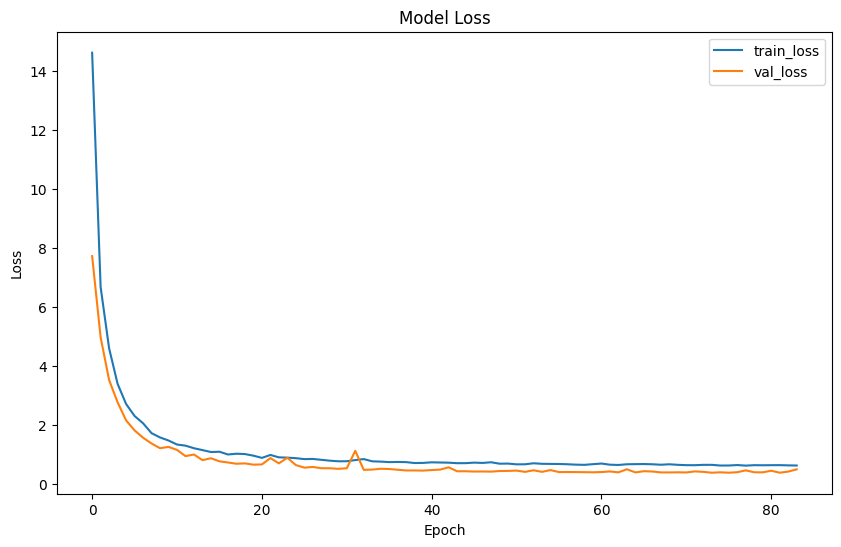

In [9]:
# Load the saved model
model = load_model('model_Near.h5')

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [10]:
# Fungsi Sistem Rekomendasi
# Fungsi Haversine
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371
    return c * r

def find_nearest_places(laundry, user_location, model_path):
    model = load_model(model_path)

    # Menghitung jarak dari lokasi pengguna ke setiap tempat
    laundry['Distance'] = laundry.apply(lambda row: haversine(user_location[1], user_location[0], row['Longitude'], row['Latitude']), axis=1)

    # Menggunakan model untuk mendapatkan prediksi rating berdasarkan lokasi pengguna
    predicted_ratings = model.predict({
        'latitude': laundry['Latitude'].values,
        'longitude': laundry['Longitude'].values,
        'distance': laundry['Distance'].values
    })

    # Menambahkan prediksi rating ke dataframe
    laundry['Predicted_Rating'] = predicted_ratings

    # Menyusun tempat berdasarkan prediksi rating dan jarak
    recommended_places = laundry.sort_values(by=['Distance', 'Predicted_Rating'], ascending=[True, False])

    # Membatasi hasil menjadi 10 tempat terdekat
    top_10_places = recommended_places.head(10)

    return top_10_places

def print_nearest_places(nearest_places, user_location):
    selected_columns = ['Name', 'Fulladdress', 'Categories', 'phone', 'Average Rating', 'Predicted_Rating', 'Distance', 'Google Maps URL','Website', 'Opening Hours', 'Layanan']

    for index, row in nearest_places.iterrows():
      print(f"Nama Laundry: {row['Name']}")
      print(f"Alamat Lengkap: {row['Fulladdress']}")
      print(f"Telepon: {row['phone']}")
      print(f"Rating: {row['Average Rating']}")
      print(f"Prediksi Rating: {row['Predicted_Rating']:.2f}")
      print(f"Jarak: {row['Distance']:.2f} km")
      print(f"Google Maps URL: {row['Google Maps URL']}")
      print(f"Website: {row['Website']}")
      print(f"Jam Buka: {row['Opening Hours']}")
      print(f"Layanan: {row['Layanan']}")
      print("\n")

# Contoh penggunaan fungsi
user_location = np.array([-7.316781, 112.761146])
nearest_places_sorted = find_nearest_places(laundry, user_location, "model_Near.h5")
print_nearest_places(nearest_places_sorted, user_location)


39/39 [==============================] - 0s 7ms/step
Nama Laundry: RA Laundry Metropolis
Alamat Lengkap: Apartemen Metropolis MS, Jl. Raya Tenggilis No.127, Jawa Timur 60292
Telepon: +62 813-5730-6710
Rating: 5.0
Prediksi Rating: 4.94
Jarak: 0.42 km
Google Maps URL: https://www.google.com/maps?cid=9396955328380271142
Website: None
Jam Buka: Sabtu: [07.00-21.00], Minggu: [07.00-21.00], Senin: [07.00-21.00], Selasa: [07.0
Layanan: just wash, dry cleaning, iron wash


Nama Laundry: Ryns Laundry
Alamat Lengkap: Jl. Raya Tenggilis No.132, Tenggilis Mejoyo, Kec. Tenggilis Mejoyo, Surabaya, Ja
Telepon: +62 819-3931-9098
Rating: 4.7
Prediksi Rating: 4.94
Jarak: 0.49 km
Google Maps URL: https://www.google.com/maps?cid=2994783431368864314
Website: https://rynslaundry.wixsite.com/website
Jam Buka: Sabtu: [06.30-22.00], Minggu: [06.30-22.00], Senin: [06.30-22.00], Selasa: [06.3
Layanan: just wash, dry cleaning, iron wash


Nama Laundry: Laundry with Care
Alamat Lengkap: Jl. Raya Tenggilis No.130, 